In [30]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchvision.models import efficientnet_v2_s
from torchsummary import summary
from sklearn.metrics import classification_report
import os, shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Callable, Tuple, Any
from pathlib import Path


from ml_dl_experiments import settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
path_to_download: str = settings.SOURCE_PATH + "datasets/"
dataset_path: str = path_to_download + "ogyeiv2/ogyeiv2"

## Скачаем данные

In [3]:
# Скачиваем данные
path = kagglehub.dataset_download("richardradli/ogyeiv2")
destination = shutil.copytree(path, path_to_download, dirs_exist_ok=True)
print("Path to dataset files:", destination)

100%|██████████| 3.24G/3.24G [17:45<00:00, 3.26MB/s] 

Extracting files...


Path to dataset files: /home/ollldman/Documents/SOURCE_PATH/datasets/


# **1. Загрузка и предобработка данных**

**Результаты этапа**

- Готовые для обучения датасеты с предобработкой, загруженные в DataLoader.

- Количество классов, изображений в обучающем и валидационном датасетах.

## Разработаем стандартную трансформацию данных

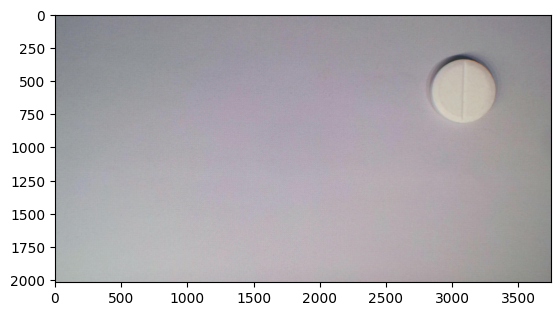

In [3]:
image = Image.open(dataset_path + "/train/images/acc_long_600_mg_s_025.jpg")
plt.imshow(image)

## Константы для трансформации изображений 

In [5]:
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224

In [6]:
train_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
])

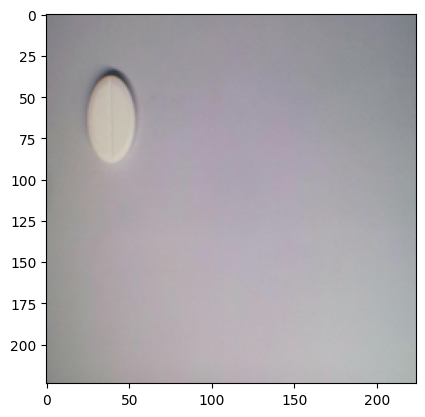

In [7]:
transformed_image = train_transform(image)
plt.imshow(transformed_image)

## Итоговые трансформации 
Для тестового, валидационного и тренировочного наборов данных:

In [8]:
train_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomVerticalFlip(p=0.3),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True), 
    T.Normalize(mean = mean, std = std)
])

In [9]:
test_valid_transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True), 
    T.Normalize(mean = mean, std = std)
])

## Создадим класс Dataset

In [14]:
# Создадим класс Dataset
torch.manual_seed(2026)

class PillsDataset(Dataset):
    """
    PyTorch Dataset для задачи классификации изображений из структурированной папки.

    Структура директории:
        dataset_root/
            ├── train/
            │   ├── classA_xxx.jpg
            │   ├── classB_yyy.jpg
            │   └── ...
            ├── valid/
            └── test/

    Имя файла содержит метку класса в первой части до первого символа '_',
    например: `naprosyn_250_mg_s_028.jpg` → класс = `"naprosyn"`.

    Args:
        image_paths (List[Path]): Список путей ко всем изображениям в выбранной подпапке.
        labels (List[str]): Список меток классов (в виде строк) для каждого изображения.
        classes (List[str]): Список уникальных классов в порядке сортировки.
        class_to_idx (Dict[str, int]): Отображение класс → индекс (число от 0 до num_classes-1).
        class_counts (Dict[str, int]): Словарь: класс → количество изображений в нём.
        data (Dict[Path, str]): Словарь: путь к файлу → строковая метка класса.
        transform (Optional[Callable]): Функция предобработки изображений (например, torchvision.transforms.Compose).
    """

    def __init__(
        self,
        dataset_root: str,
        split: str,
        transform: Optional[Callable[[Any], torch.Tensor]] = None,
    ) -> None:
        """
        Инициализирует датасет.

        Args:
            dataset_root (str): Путь к корневой директории датасета.
            split (str): Подмножество данных — должно быть одним из {'train', 'valid', 'test'}.
            transform (Optional[Callable]): Преобразование изображения (например, нормализация, ресайз и т.д.).

        Raises:
            ValueError: Если `split` не входит в допустимый набор.
            FileNotFoundError: Если указанная подпапка не существует.
            ValueError: Если не удалась трансформация
        """
        if split not in {"train", "valid", "test"}:
            raise ValueError(f"split must be 'train', 'valid', or 'test', got '{split}'")

        self.split = split
        self._images= "images"
        self.dataset_root = Path(dataset_root)
        split_dir = self.dataset_root / split / self._images

        if not split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        # Сбор всех изображений и извлечение меток
        self.image_paths: List[Path] = []
        self.labels: List[str] = []
        self.data: Dict[Path, str] = {}

        valid_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}

        for file_path in split_dir.iterdir():
            if file_path.suffix.lower() in valid_extensions:
                try:
                    class_label = file_path.stem.split("_")[0]
                except IndexError:
                    raise ValueError(f"Cannot parse class from filename: {file_path.name}")
                self.image_paths.append(file_path)
                self.labels.append(class_label)
                self.data[file_path] = class_label

        if not self.image_paths:
            raise ValueError(f"No valid images found in {split_dir}")

        unique_classes = sorted(set(self.labels))
        self.classes: List[str] = unique_classes
        self.class_to_idx: Dict[str, int] = {cls: i for i, cls in enumerate(unique_classes)}

        # Подсчёт количества изображений на класс
        self.class_counts: Dict[str, int] = {cls: 0 for cls in unique_classes}
        for label in self.labels:
            self.class_counts[label] += 1

        # Сохраняем transform
        self.transform = transform

    def __len__(self) -> int:
        """Возвращает общее количество изображений в датасете."""
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Returns:
            Tuple[torch.Tensor, int]: Изображение как тензор и целочисленная метка класса.

        Raises:
            IOError: Если изображение не может быть загружено.
        """
        img_path = self.image_paths[idx]
        label_str = self.labels[idx]
        label_idx = self.class_to_idx[label_str]

        # Загрузка изображения
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise IOError(f"Failed to load image {img_path}: {e}")

        # Применение трансформаций
        if self.transform is not None:
            image = self.transform(image)
        else:
            raise ValueError(f"Failed to transform image {img_path}")

        return image, label_idx

## Создадим наборы данных и проанализируем баланс классов в них

In [15]:
train_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="train",
    transform = train_transform
)
test_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="test",
    transform=test_valid_transform
)
valid_dataset = PillsDataset(
    dataset_root=dataset_path,
    split="valid",
    transform=test_valid_transform
)

## Балансы классов

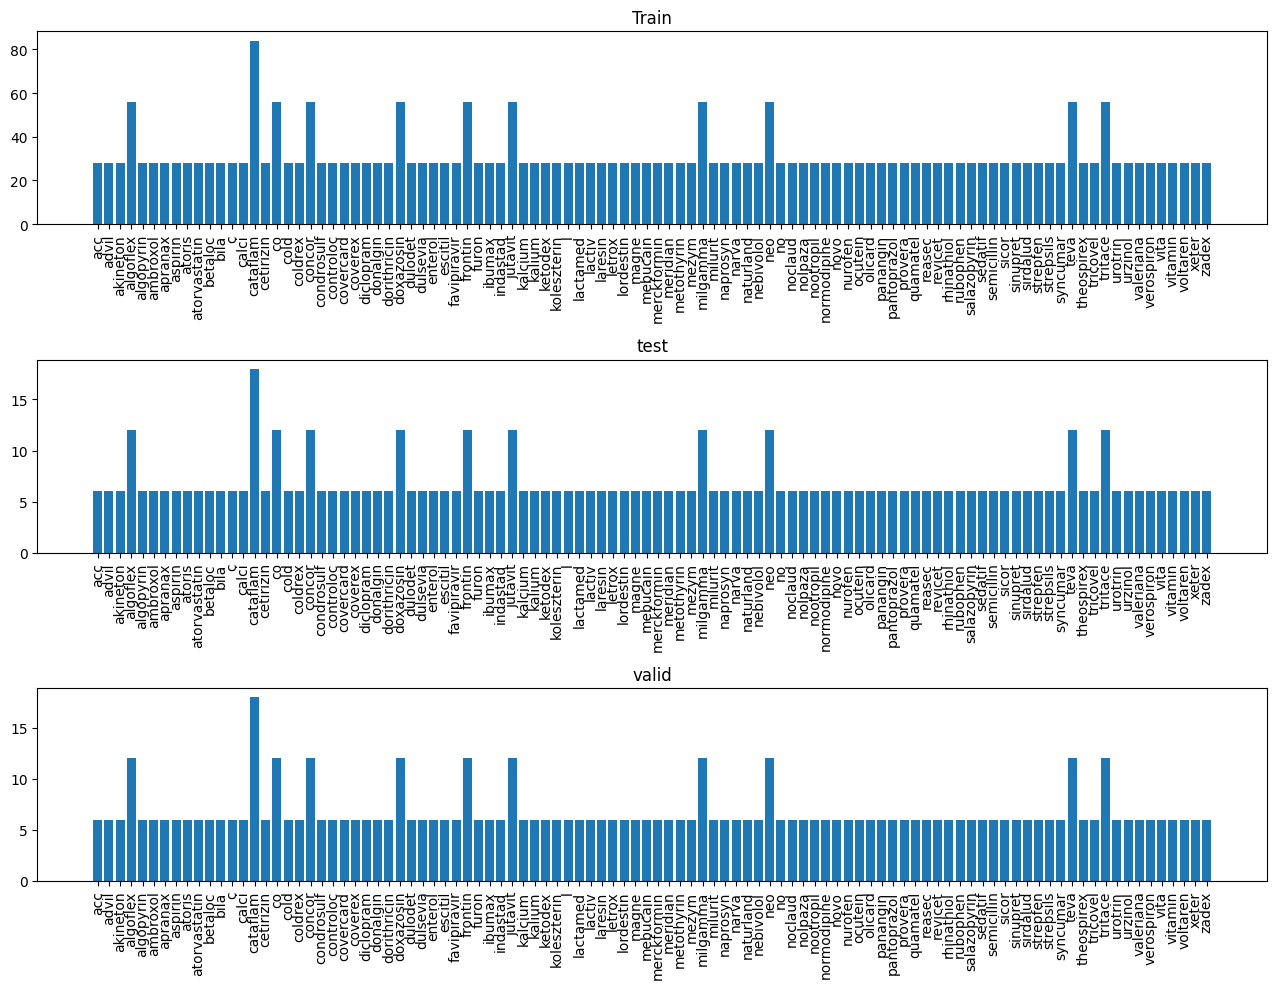

In [ ]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(13, 10)
)
# test
axes[0].bar(
    x=train_dataset.class_counts.keys(), 
    height=train_dataset.class_counts.values())
axes[0].set_title("Train")
ticks = range(len(train_dataset.class_counts.keys()))
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(train_dataset.class_counts.keys(), rotation = 90)

# train

axes[1].bar(
    x=test_dataset.class_counts.keys(), 
    height=test_dataset.class_counts.values())
axes[1].set_title("Test")
ticks = range(len(test_dataset.class_counts.keys()))
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(test_dataset.class_counts.keys(), rotation = 90)

# valid

axes[2].bar(
    x=valid_dataset.class_counts.keys(), 
    height=valid_dataset.class_counts.values())
axes[2].set_title("Valid")
ticks = range(len(valid_dataset.class_counts.keys()))
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(valid_dataset.class_counts.keys(), rotation = 90)

plt.tight_layout()
plt.show()

In [28]:
num_classes = len(train_dataset.classes)
num_classes

100

## Создадим DataLoader

In [ ]:
batch_size = 32


# 2. Обявление модели

Создать классификатор изображений, подходящий для классификации таблеток. Воспользуемся  Transfer Learning. Итоговый классификатор, готовый к обучению или дообучению, поместим в переменную model.

# 3. Дообучение

**Результаты этапа**

- Распечатка ошибок на обучающем и тестовом датасетах в конце каждой эпохи.
- Файл с моделью meds_classifier.pt.

# 4. Оценка качества

**Результаты этапа**

- Распечатка Precision, Recall, F1 для каждого класса + общая accuracy для классификатора таблеток с accuracy выше 75%.
- Текст с ответами на вопросы:
    - На каких 5 классах модель ошибается чаще всего?
    - Почему модель может ошибаться на этих классах?
    - На каких классах модель не совершает ошибок?
    - Почему эти классы модель распознаёт безошибочно?
    - Как можно улучшить точность классификатора?
    - Как ещё можно проанализировать результаты и ошибки модели?